<a href="https://colab.research.google.com/github/Vishnu-3101/BitcoinResearch/blob/main/DataPreprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [113]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from nltk.tokenize import word_tokenize
import nltk
from nltk.corpus import stopwords
import re
from wordcloud import WordCloud
import seaborn as sns
from scipy.stats import pearsonr

In [153]:
nltk.download('stopwords')
nltk.download('punkt')
custom_stop_words = {'bitcoin','btc','de','la','en'}
english_stopwords = set(stopwords.words('english'))
french_stopwords = set(stopwords.words('french'))
stop_words = english_stopwords.union(french_stopwords)
stop_words.update(custom_stop_words)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [186]:
class TweetsDataset:
    def __init__(self,dataset_path):
        self.tweets = pd.read_csv(dataset_path)
        self.data = self.tweets

    def group_dataset_by_date(self):
        self.tweets['date'] = pd.to_datetime(self.tweets['date'])
        self.tweets = self.tweets.sort_values(by='date',na_position='first')
        self.tweets = self.tweets.dropna()
        self.aggregated_tweets = self.tweets.groupby('date')['text_split'].agg(lambda x: ' '.join(x)).reset_index()
        return self.aggregated_tweets

    def preprocessing(self,data):
        for i,t in enumerate(tqdm(data['text_split'])):
            text = str(data.loc[i,'text_split'])
            text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
            text = text.lower()
            text = ' '.join([word for word in word_tokenize(text) if word.isalpha()])
            text = ' '.join([word for word in word_tokenize(text) if word not in stop_words])
            data.loc[i,'text_split'] = text
        return data

    def word_cloud(self,data):
        word_cloud = WordCloud(width = 800, height=600, max_words = 200, background_color='white',collocations=False).generate(' '.join(data))
        plt.figure(figsize = (10,8))
        plt.imshow(word_cloud,interpolation = 'bilinear')
        plt.axis('off')
        plt.show()

    def top_20_words(self,data):
        all_words = ' '.join(data).split()
        word_freq = nltk.FreqDist(all_words)
        word_freq_df = pd.DataFrame(list(word_freq.items()),columns=['word','frequency']).sort_values(by='frequency',ascending = False)
        plt.figure(figsize = (10,8))
        sns.barplot(x='frequency',y='word',data=word_freq_df.head(20))
        plt.title('Top 20 words in the corpus')
        plt.show()

    def visualize_by_volume(self):
        self.tweets_per_day = self.tweets.groupby(self.tweets['date'].dt.date)['text_split'].count().reset_index()
        self.tweets_per_day.columns = ['Date', 'Tweets_Count']
        plt.figure(figsize=(12, 5))
        sns.lineplot(x='Date', y=self.tweets_per_day['Tweets_Count'], data=self.tweets_per_day)
        plt.title('Tweet Volume Over Time')
        plt.xlabel('Date')
        plt.ylabel('Tweet Count')
        plt.show()

    def correlation(self,x,y):
        correlation_coefficient, p_value = pearsonr(x, y)

        # Display the correlation coefficient and p-value
        print(f"Correlation Coefficient: {correlation_coefficient}")
        print(f"P-value: {p_value}")

        # Scatter plot to visualize the relationship
        plt.scatter(x, y)
        plt.title('Scatter Plot: Tweets Count vs. Price')
        plt.xlabel('Number of Tweets per Day')
        plt.ylabel('Bitcoin Price')
        plt.show()

    def get_5day_data(self,data):
        dataset = []

        # Iterate through the data to create the dataset with 5-day lag
        for i in range(5, len(data)):
            # Extract the tweets for the current day and the past 4 days
            tweets_window = data['text_split'].iloc[i-5:i].tolist()
            # Append the data to the dataset
            dataset.append([tweets for tweets in tweets_window])

        # Convert the dataset to a DataFrame for further analysis if needed
        columns = ['Tweets_Day_1', 'Tweets_Day_2', 'Tweets_Day_3', 'Tweets_Day_4', 'Tweets_Day_5']
        dataset_df = pd.DataFrame(dataset, columns=columns)
        return dataset_df


In [187]:
dataset_path = '/content/drive/MyDrive/ResearchPaper/Dataset/tweets/combined_tweets_2015_labeled.csv'
tweets = TweetsDataset(dataset_path)

In [188]:
aggregated_data = tweets.group_dataset_by_date()

In [189]:
aggregated_data = tweets.preprocessing(aggregated_data)

100%|██████████| 364/364 [00:40<00:00,  8.92it/s]


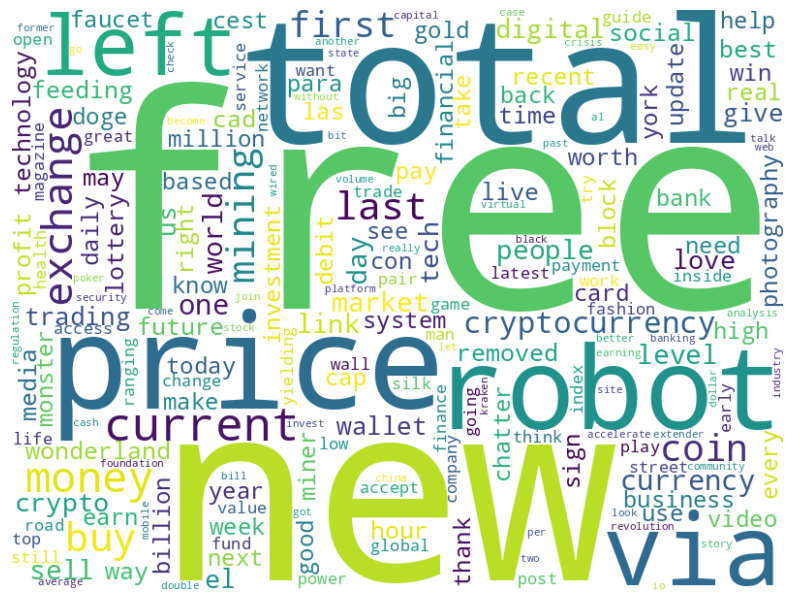

In [182]:
tweets.word_cloud(aggregated_data['text_split'])

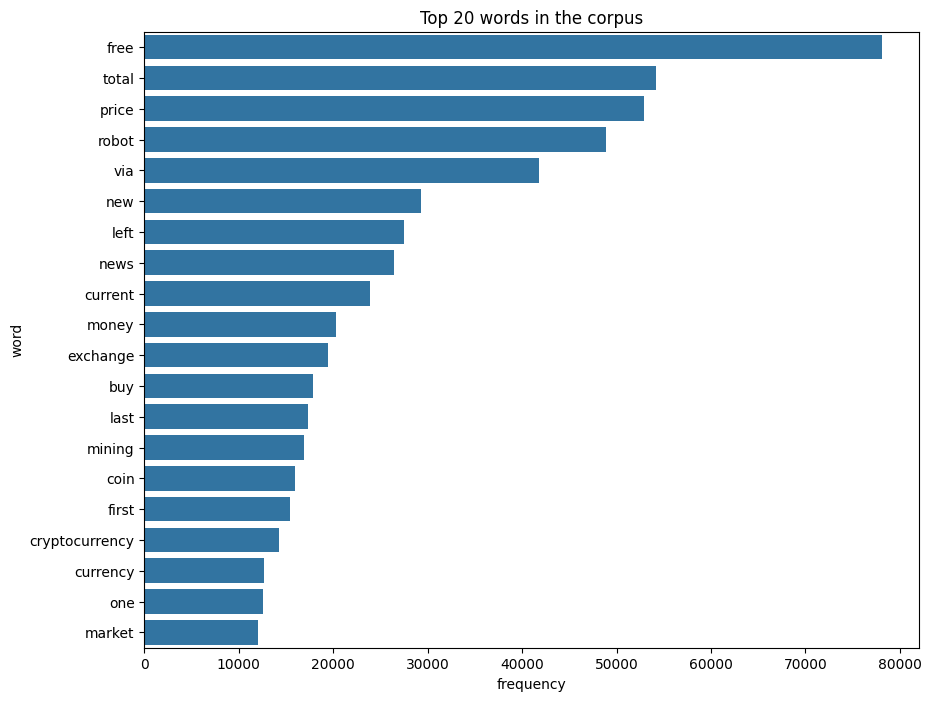

In [183]:
tweets.top_20_words(aggregated_data['text_split'])

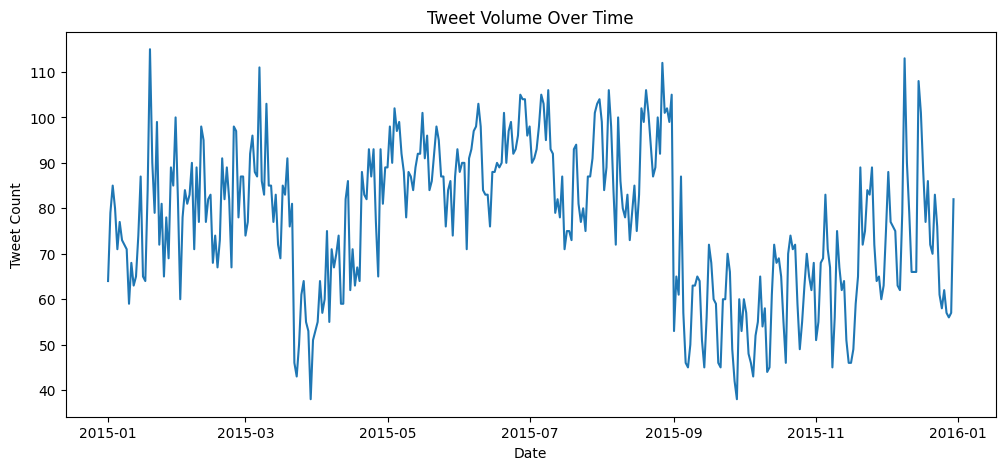

In [184]:
tweets.visualize_by_volume(tweets.tweets_per_day['Tweets_Count'],)

Correlation Coefficient: -0.12564665034547
P-value: 0.016464513386851936


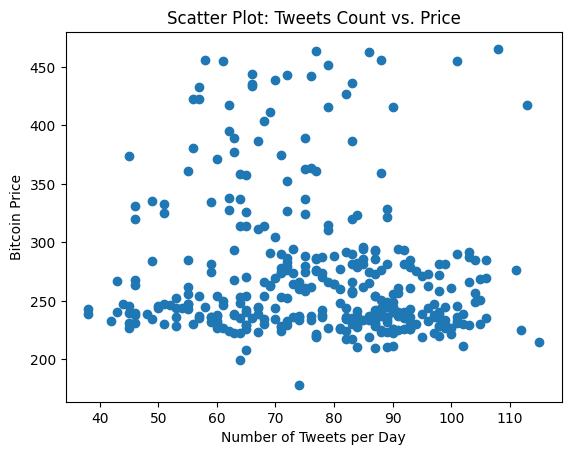

In [185]:
tweets.correlation(tweets.tweets_per_day['Tweets_Count'], btc_data['Close'][:364])

In [190]:
data_5day = tweets.get_5day_data(aggregated_data)
data_5day.head()

,Tweets_Day_1,Tweets_Day_2,Tweets_Day_3,Tweets_Day_4,Tweets_Day_5
0,blocked thats achievement still like ser patri...,take time donate little got attempt account sh...,hitchhiker hand miner mining module brand new ...,big business winkel via gratis whatever mind m...,product node coin standard edition brass ni id...
1,take time donate little got attempt account sh...,hitchhiker hand miner mining module brand new ...,big business winkel via gratis whatever mind m...,product node coin standard edition brass ni id...,di exchange analysis week year ahead boy sure ...
2,hitchhiker hand miner mining module brand new ...,big business winkel via gratis whatever mind m...,product node coin standard edition brass ni id...,di exchange analysis week year ahead boy sure ...,potential another story platform slur tor good...
3,big business winkel via gratis whatever mind m...,product node coin standard edition brass ni id...,di exchange analysis week year ahead boy sure ...,potential another story platform slur tor good...,default miracle bought last would millionaire ...
4,product node coin standard edition brass ni id...,di exchange analysis week year ahead boy sure ...,potential another story platform slur tor good...,default miracle bought last would millionaire ...,founder twitter working alongside team san pro...


In [22]:
aggregated_tweets.head()

,date,text_split
0,2015-01-01,blocked me thats my achievement still like bit...
1,2015-01-02,take some time to donate me little bitcoin bit...
2,2015-01-03,hitchhiker in hand miner bitcoin bitcoin minin...
3,2015-01-04,into big business winkel via en gratis whateve...
4,2015-01-05,of product node coin standard edition brass ni...


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [82]:
# french_stopwords

In [83]:
def preprocessing():
  for i,t in enumerate(tqdm(aggregated_tweets['text_split'])):
    text = str(aggregated_tweets.loc[i,'text_split'])
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    text = text.lower()
    text = ' '.join([word for word in word_tokenize(text) if word.isalpha()])
    text = ' '.join([word for word in word_tokenize(text) if word not in stop_words])
    aggregated_tweets.loc[i,'text_split'] = text
  return aggregated_tweets

In [84]:
preocessed_tweets = preprocessing()

100%|██████████| 364/364 [00:25<00:00, 14.55it/s]


In [85]:
aggregated_tweets['text_split'][0]

'blocked thats achievement still like ser patria para trust sell last exchange pair yielding ranging new hour high tech might save world world meet year two based respond third air disaster year wow holy text book buy signal batman silly via far reaction new article mostly positive except crowd trying feverishly insult may integrate apple pay parking rise leader crypto trend ever since bowl law auld syne someday block chain break free power distributed via happy new year better accept tip via claim cryptocurrency exchange platform never easy use interesting year excited see store happy new year smith shoe line via spare evangelist prison super cryptocurrency regulation still far away conference state bank year old elance job got parking ticket city looking apple pay ways pay el giant top regulation still far away top fear index could solve volatility problem growth year dinner ways visit one step forward bought auto copy trade free conference apple pay pay parking got parking ticket ci

In [86]:
def visualize():
  combined_text = ' '.join(aggregated_tweets['text_split'])
  word_cloud = WordCloud(width = 800, height=600, max_words = 200, background_color='white',collocations=False).generate(combined_text)
  plt.figure(figsize = (10,8))
  plt.imshow(word_cloud,interpolation = 'bilinear')
  plt.axis('off')
  plt.show()

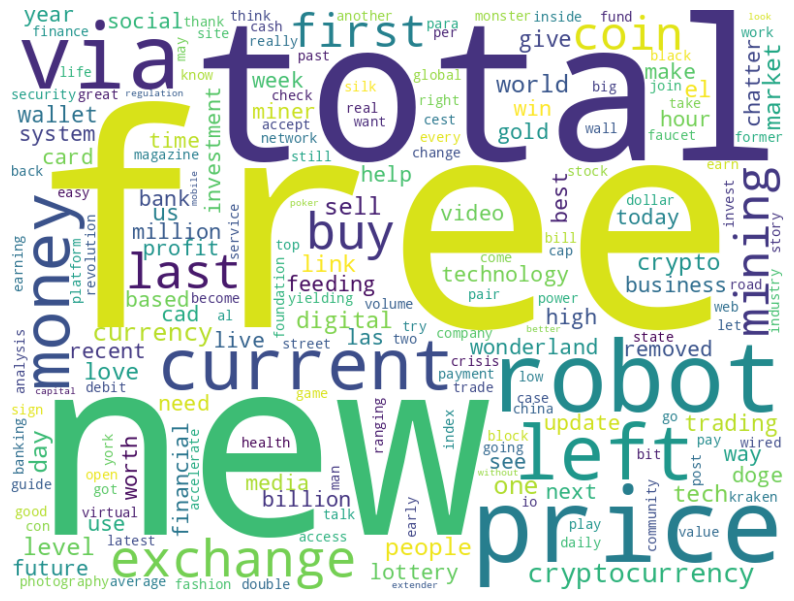

In [87]:
visualize()

In [126]:
def top_20_words():
  all_words = ' '.join(preocessed_tweets['text_split']).split()
  word_freq = nltk.FreqDist(all_words)
  word_freq_df = pd.DataFrame(list(word_freq.items()),columns=['word','frequency']).sort_values(by='frequency',ascending = False)
  plt.figure(figsize = (10,8))
  sns.barplot(x='frequency',y='word',data=word_freq_df.head(20))
  plt.title('Top 20 words in the corpus')
  plt.show()

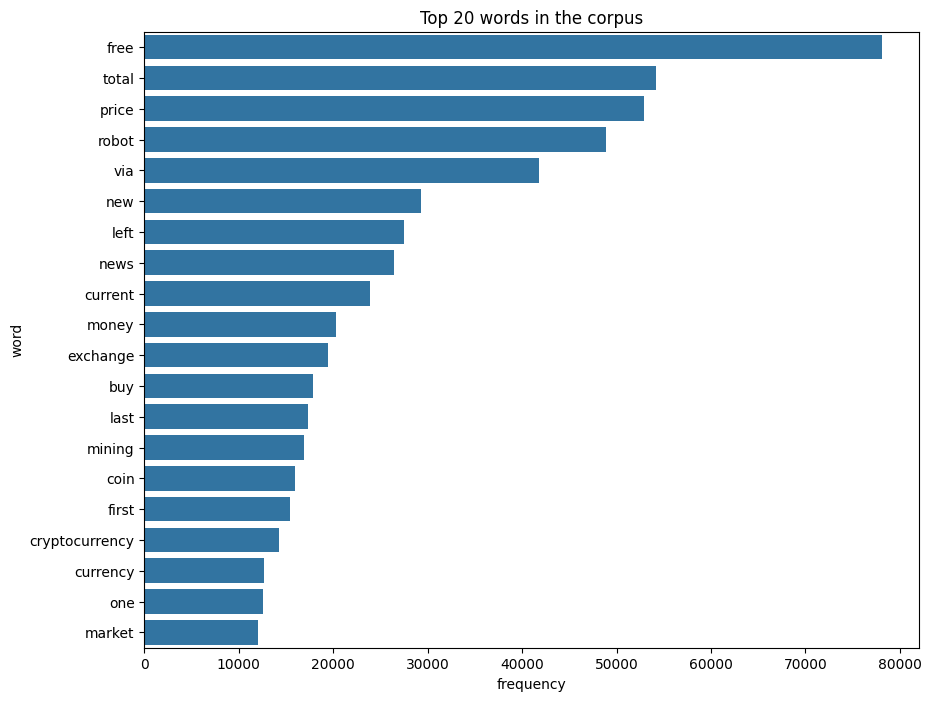

In [127]:
top_20_words()

In [106]:
tweets_per_day = tweets.groupby(tweets['date'].dt.date)['text_split'].count().reset_index()

# Rename columns for clarity
tweets_per_day.columns = ['Date', 'Tweets_Count']

# Display the resulting DataFrame
tweets_per_day.head()

,Date,Tweets_Count
0,2015-01-01,64
1,2015-01-02,79
2,2015-01-03,85
3,2015-01-04,80
4,2015-01-05,71


In [109]:
def visualize_by_volume():
  plt.figure(figsize=(12, 5))
  sns.lineplot(x='Date', y=tweets_per_day['Tweets_Count'], data=tweets_per_day)
  plt.title('Tweet Volume Over Time')
  plt.xlabel('Date')
  plt.ylabel('Tweet Count')
  plt.show()

In [ ]:
def visualize_prices():
  plt.figure(figsize=(12,5))
  sns.lineplot(x='Date',y='Close',data=btc_data)
  plt.title('Bitcoin prices in the year 2015')
  plt.xlabel('Date')
  plt.ylabel('Price')
  plt.show()

In [ ]:
btc_data = pd.read_csv('/content/drive/MyDrive/ResearchPaper/Dataset/BTC_data/BTC-USD_2015.csv')
btc_data.head()

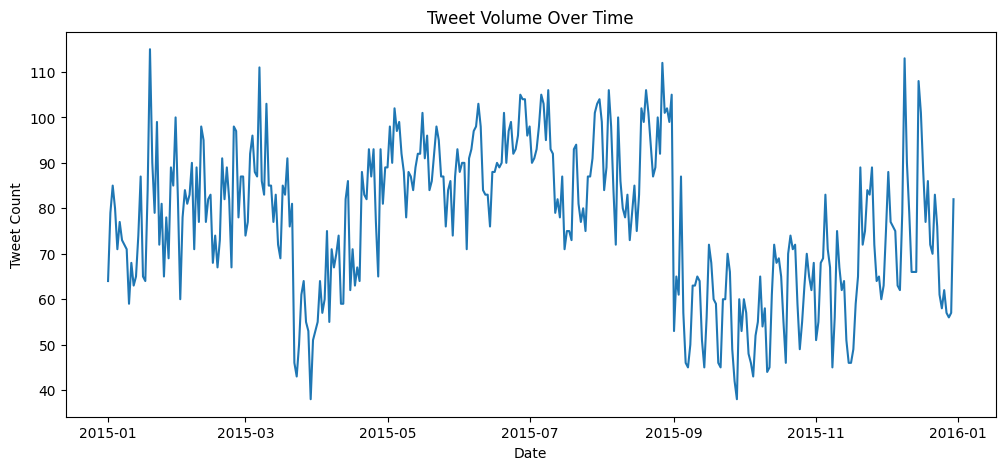

In [110]:
visualize_by_volume()

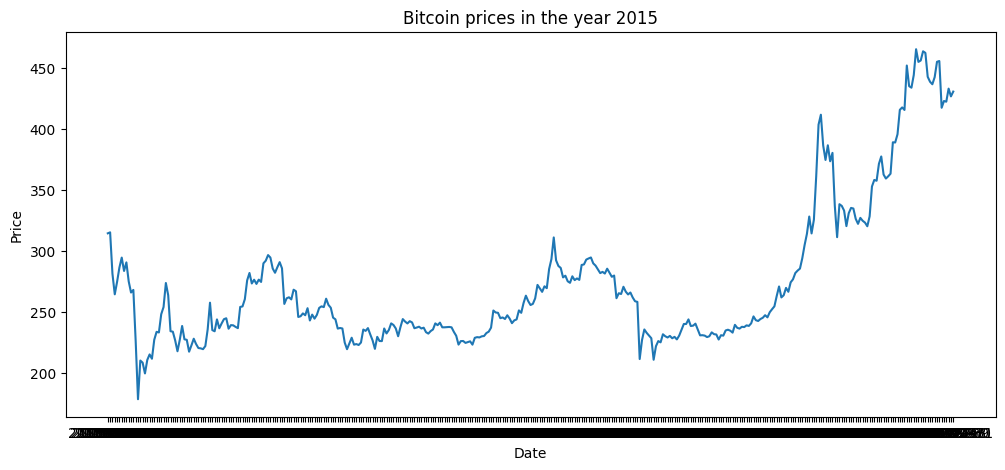

In [112]:
visualize_prices()

In [121]:
len(tweets_per_day['Tweets_Count'])

364

In [123]:
len(btc_data['Close'][:364])

364

Correlation Coefficient: -0.12564665034547
P-value: 0.016464513386851936


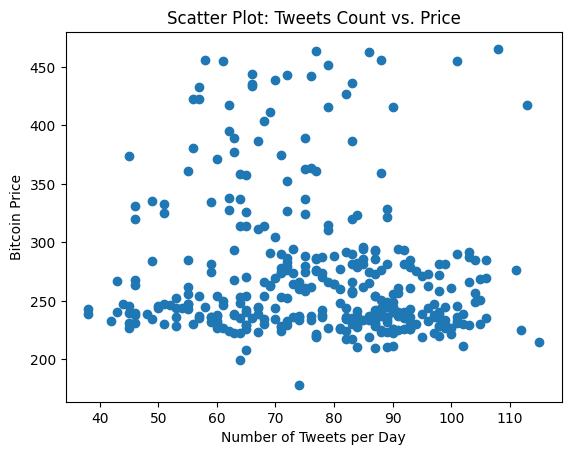

In [150]:
data_5day = get_5day_data()

In [152]:
data_5day.head()

,Tweets_Day_1,Tweets_Day_2,Tweets_Day_3,Tweets_Day_4,Tweets_Day_5
0,blocked thats achievement still like ser patri...,take time donate little got attempt account sh...,hitchhiker hand miner mining module brand new ...,big business winkel via gratis whatever mind m...,product node coin standard edition brass ni id...
1,take time donate little got attempt account sh...,hitchhiker hand miner mining module brand new ...,big business winkel via gratis whatever mind m...,product node coin standard edition brass ni id...,di exchange analysis week year ahead boy sure ...
2,hitchhiker hand miner mining module brand new ...,big business winkel via gratis whatever mind m...,product node coin standard edition brass ni id...,di exchange analysis week year ahead boy sure ...,potential another story platform slur tor good...
3,big business winkel via gratis whatever mind m...,product node coin standard edition brass ni id...,di exchange analysis week year ahead boy sure ...,potential another story platform slur tor good...,default miracle bought last would millionaire ...
4,product node coin standard edition brass ni id...,di exchange analysis week year ahead boy sure ...,potential another story platform slur tor good...,default miracle bought last would millionaire ...,founder twitter working alongside team san pro...


In [142]:
print(dataset[0])

[['blocked thats achievement still like ser patria para trust sell last exchange pair yielding ranging new hour high tech might save world world meet year two based respond third air disaster year wow holy text book buy signal batman silly via far reaction new article mostly positive except crowd trying feverishly insult may integrate apple pay parking rise leader crypto trend ever since bowl law auld syne someday block chain break free power distributed via happy new year better accept tip via claim cryptocurrency exchange platform never easy use interesting year excited see store happy new year smith shoe line via spare evangelist prison super cryptocurrency regulation still far away conference state bank year old elance job got parking ticket city looking apple pay ways pay el giant top regulation still far away top fear index could solve volatility problem growth year dinner ways visit one step forward bought auto copy trade free conference apple pay pay parking got parking ticket 

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')  # You can adjust max_features as needed
encoded_tweets = vectorizer.fit_transform(aggregated_tweets['text_split'])

In [ ]:
lagged_encoded_tweets = []
for i in range(5, encoded_tweets.shape[0]):
    lagged_tweets = encoded_tweets[i-5:i, :].reshape(1,-1)  # Concatenate the encoded tweets of the past 5 days
    lagged_encoded_tweets.append(lagged_tweets)

In [ ]:
lagged_encoded_tweets = np.array(lagged_encoded_tweets)

In [ ]:
lagged_encoded_tweets[0]

<1x25000 sparse matrix of type '<class 'numpy.float64'>'
	with 5437 stored elements in COOrdinate format>